# Annual temperature anomalies relative to the pre-industrial period

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.nonparametric.smoothers_lowess import lowess

## EDA


### Reading the Data and creating Time Series


In [5]:
db = pd.read_csv("temperature-anomaly.csv")
db = db[["Year","Global average temperature anomaly relative to 1861-1890","Lower bound of the annual temperature anomaly (95% confidence interval)","Upper bound of the annual temperature anomaly (95% confidence interval)"]]
db = db.rename(columns={
    "Global average temperature anomaly relative to 1861-1890" : "Anomaly",
    "Lower bound of the annual temperature anomaly (95% confidence interval)" : "Lower Bound",
    "Upper bound of the annual temperature anomaly (95% confidence interval)" : "Upper Bound"
})
print(db.head())

   Year   Anomaly  Lower Bound  Upper Bound
0  1850 -0.055414    -0.226959     0.116131
1  1851  0.128948    -0.049570     0.307466
2  1852  0.132899    -0.047085     0.312882
3  1853  0.091943    -0.067712     0.251598
4  1854  0.070777    -0.070414     0.211968


In [6]:
dates = pd.date_range(start='1850', periods=len(db), freq='YE')
mytimeseries = pd.DataFrame(db.iloc[:, 1:].values, index=dates, columns=db.columns[1:])

print("\nTime series info:")
print(mytimeseries.info())
print(mytimeseries.head())


Time series info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 1850-12-31 to 2025-12-31
Freq: YE-DEC
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Anomaly      176 non-null    float64
 1   Lower Bound  176 non-null    float64
 2   Upper Bound  176 non-null    float64
dtypes: float64(3)
memory usage: 5.5 KB
None
             Anomaly  Lower Bound  Upper Bound
1850-12-31 -0.055414    -0.226959     0.116131
1851-12-31  0.128948    -0.049570     0.307466
1852-12-31  0.132899    -0.047085     0.312882
1853-12-31  0.091943    -0.067712     0.251598
1854-12-31  0.070777    -0.070414     0.211968


For this analysis, the primary focus is on the global average temperature anomaly, for which our dataset has data with anual frequency from the Industrial Revolution to the present day (1850-2025, 175 years). While the dataset provides upper and lower bounds to indicate uncertainty, these values are not essential for understanding the overall trend. The average anomaly alone captures how much the Earth's surface temperature has deviated from pre-industrial levels each year, which is why only the average anomaly will be used from here on out.

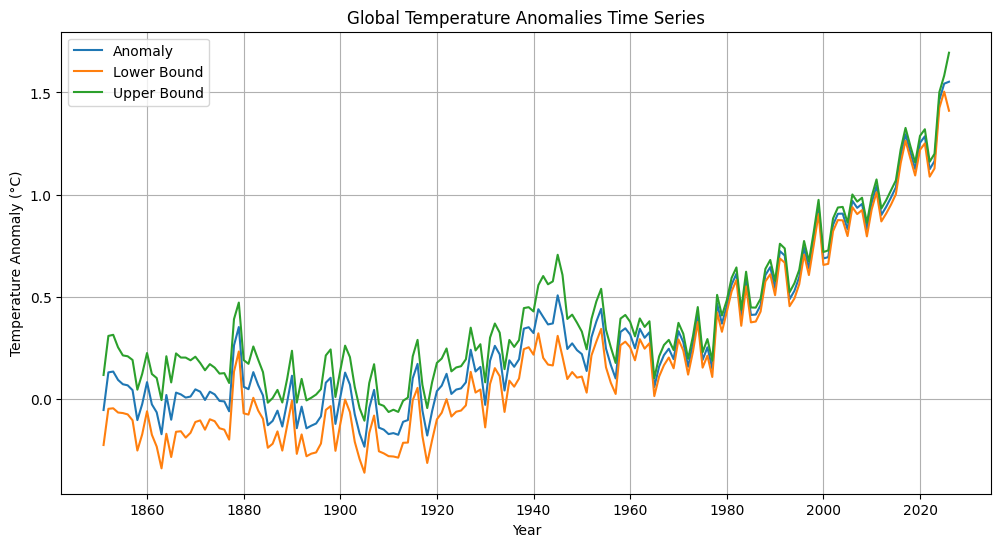

In [7]:
plt.figure(figsize=(12, 6))
for col in mytimeseries.columns:
    plt.plot(mytimeseries.index, mytimeseries[col], label=col)

plt.title("Global Temperature Anomalies Time Series")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.grid(True)
plt.legend()
plt.show()

For this analysis, the primary focus is on the global average temperature anomaly. While the dataset provides upper and lower bounds to indicate uncertainty, these values are not essential for understanding the overall trend. The average anomaly alone captures how much the Earth's surface temperature has deviated from pre-industrial levels each year.

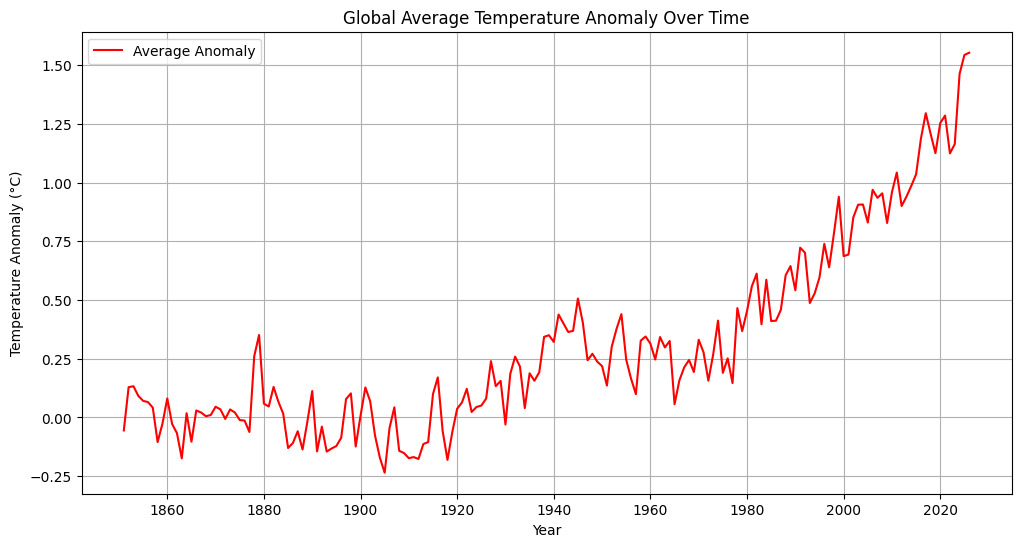

In [8]:
average_anomaly = mytimeseries['Anomaly']


plt.figure(figsize=(12, 6))
plt.plot(average_anomaly.index, average_anomaly, color='red', label='Average Anomaly')
plt.title("Global Average Temperature Anomaly Over Time")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.grid(True)
plt.legend()
plt.show()

By concentrating on the average, we can clearly observe the long-term warming trend without the distraction of additional columns. This simplification makes the analysis cleaner, easier to interpret, and directly highlights the magnitude of global temperature changes over time.

### Descriptive Analysis of the Time Series

The series shows a clear upward trend over the past 170+ years, indicating a gradual increase in global temperatures relative to
   pre-industrial levels.

Although there is a general warming trend, the anomalies fluctuate from year to year, with some years being cooler or warmer than the previous year.

The early 20th century shows relatively small deviations, while the late 20th and early 21st centuries exhibit larger positive anomalies, with record highs in recent decades.

The warming trend is gradual over decades, rather than abrupt jumps, although occasional short-term dips are visible due to natural variability.


## Time Series Components

In this section, we analyze the main components of the dataset before applying a formal time series decomposition.

#### 1. Trend
The series shows a **clear upward trend** in global temperature anomalies.
The trend is not perfectly linear: warming is modest before the mid-20th century and accelerates strongly in recent decades.

#### 2. Seasonality

Since the data is **annual** and aggregated at the **global level**, no intra-year seasonal pattern can be observed.
- Hemispheric seasons cancel each other out (summer in one hemisphere corresponds to winter in the other).
- Furthermore, the anomaly calculation is performed relative to a baseline climatology, which already removes the average seasonal cycle.

As a result, this dataset only reflects **long-term trend** and **year-to-year variability**, but not seasonal fluctuations.


#### 3. Variance and Heteroscedasticity
Some evidence of heteroscedasticity is present. In earlier decades (late 19th and early 20th century), the spread of anomalies appears wider. Over time, the range between upper and lower fluctuations narrows.

This narrowing is largely due to **improvements in scientific measurement and global coverage** rather than a real change in climate variability. As more weather stations, ocean buoys, and later satellites were incorporated, the estimates of global temperature anomalies became more precise, reducing uncertainty.

Thus, while the variance of the series shows modest changes, these are best interpreted as **data quality effects** rather than fundamental changes in climate dynamics.

#### 4. Additive vs Multiplicative Structure
Despite small changes in variance, the dataset is best represented by an **additive model**:


$$y_t=T_t + R_t$$


- The **trend** captures the long-term warming signal.
- The **noise** represents short-term variability .
- A multiplicative model is not appropriate, since fluctuations do not scale with the level of the series.



## Time Series Decomposition

In this section we separate the series into its core parts to understand what drives the behavior: a smooth trend (long-run warming) and a remainder (short-run fluctuations). Annual data have no within-year seasonality, so a seasonal component is not modeled.

#### Method (additive, annual)

#### 1. Smoothing for Trend
- **LOWESS:** a locally weighted smoother that traces the central path while ignoring year-to-year noise.
- **10-year centered rolling mean:** an assumption-light average of a 10-year window (≈ 5 years before + 5 years after each year).

#### 2. Remainder
We define the remainder as the observed anomaly minus the smooth trend:
$$
\mathrm{Remainder}_t \;=\; \mathrm{Anomaly}_t \;-\; \widehat{\mathrm{Trend}}_t
$$

We analyze the remainder to check **serial correlation** (persistence) and **variance changes** (heteroscedasticity).

#### 3. Uncertainty
We visualize the **95% confidence band** (*Lower Bound* / *Upper Bound*) around the anomaly to communicate **estimation uncertainty**.


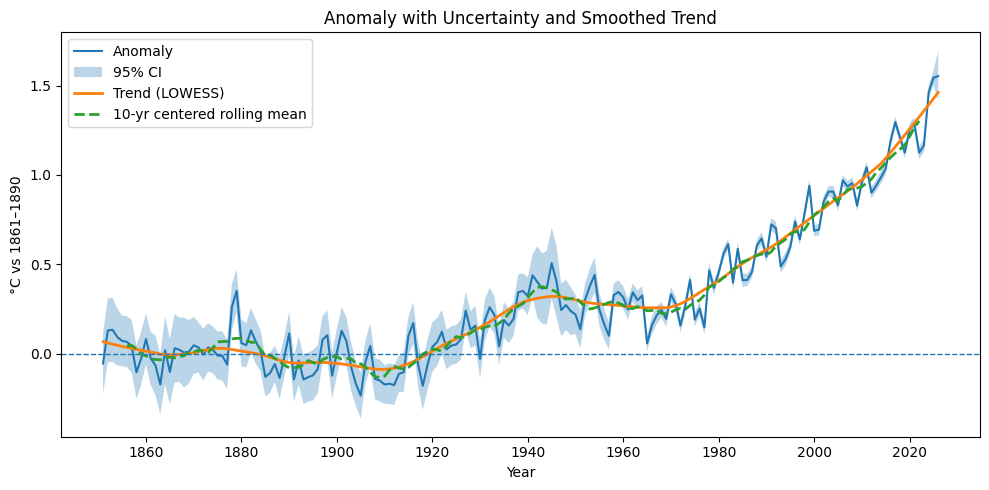

In [9]:
ts = mytimeseries[['Anomaly','Lower Bound','Upper Bound']].sort_index()
x      = np.arange(len(ts))                            
years  = ts.index.to_pydatetime()                         
an     = ts['Anomaly'].to_numpy(dtype=float)
lo_ci  = ts['Lower Bound'].to_numpy(dtype=float)
hi_ci  = ts['Upper Bound'].to_numpy(dtype=float)


low = lowess(an, x, frac=0.15, return_sorted=False)      
roll = ts['Anomaly'].rolling(10, center=True).mean().to_numpy()
remainder = an - low

plt.figure(figsize=(10,5))
plt.plot(years, an, label='Anomaly')
plt.fill_between(years, lo_ci, hi_ci, alpha=0.3, label='95% CI')
plt.plot(years, low, linewidth=2, label='Trend (LOWESS)')
plt.plot(years, roll, linewidth=2, linestyle='--', label='10-yr centered rolling mean')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('Anomaly with Uncertainty and Smoothed Trend')
plt.xlabel('Year'); plt.ylabel('°C vs 1861–1890'); plt.legend()
plt.tight_layout(); plt.show()

Both smoothers (LOWESS and the 10-year mean) tell the same story: a persistent long-run warming. Early decades hover near the baseline; the curve bends upward in the 20th century and rises more sharply in recent decades, which is consistent with acceleration of warming.

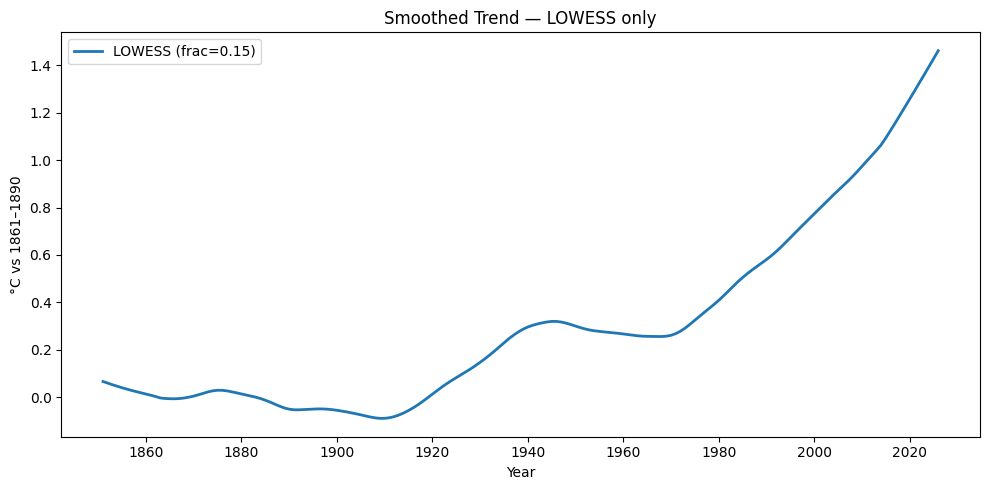

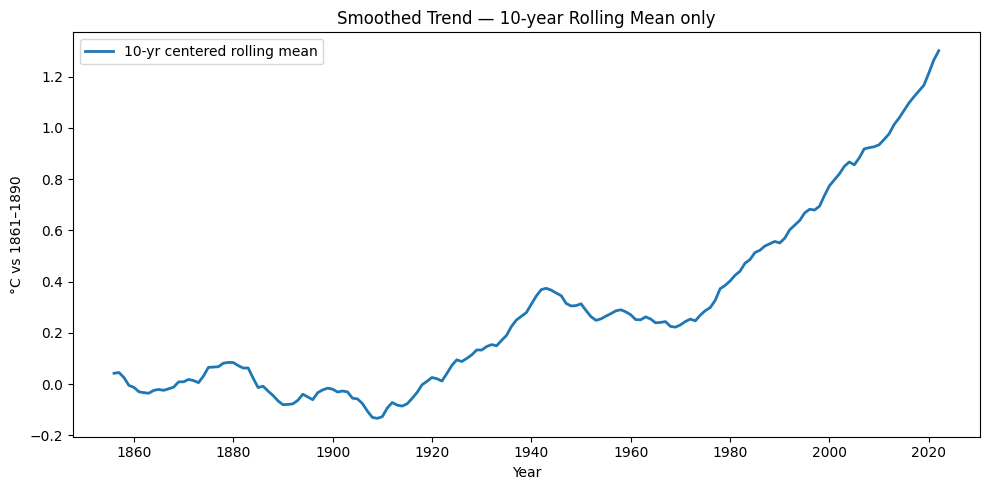

In [10]:

plt.figure(figsize=(10,5))
plt.plot(years, low, linewidth=2, label="LOWESS (frac=0.15)")
plt.title("Smoothed Trend — LOWESS only")
plt.xlabel("Year"); plt.ylabel("°C vs 1861–1890")
plt.legend(); plt.tight_layout()
plt.show()

# ----- 10-year centered rolling mean only -----
plt.figure(figsize=(10,5))
plt.plot(years, roll, linewidth=2, label="10-yr centered rolling mean")
plt.title("Smoothed Trend — 10-year Rolling Mean only")
plt.xlabel("Year"); plt.ylabel("°C vs 1861–1890")
plt.legend(); plt.tight_layout()
plt.show()

#### **Why two smoothers?**

- LOWESS is flexible and can reveal gentle changes in slope without choosing a hard breakpoint.

- The 10-year mean is transparent and robust: if both agree, the result isn’t an artifact of one method.

#### **Remainder**

We observed the remainder to look for the following:
- Is it centered around 0 (no lingering trend)?
- Is the variance roughly stable or does it change over time?
- Is there serial correlation (do changes cluster from year to year)?


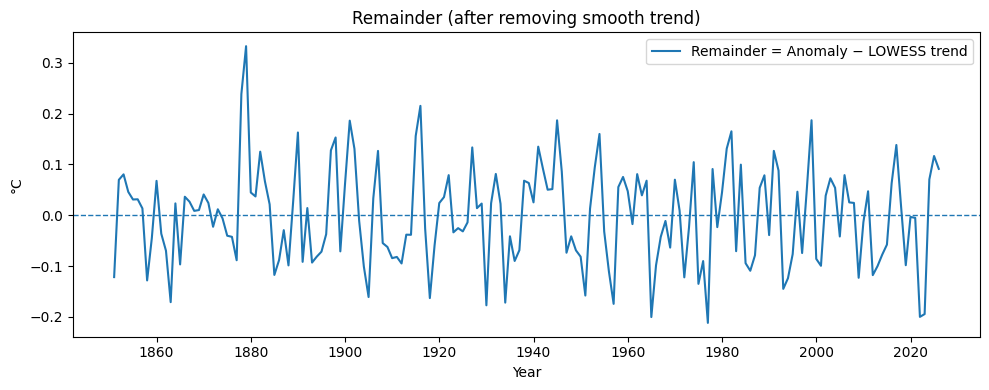

In [11]:
plt.figure(figsize=(10,4))
plt.plot(years, remainder, label='Remainder = Anomaly − LOWESS trend')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('Remainder (after removing smooth trend)')
plt.xlabel('Year'); plt.ylabel('°C'); plt.legend()
plt.tight_layout(); plt.show()


After extracting a smooth trend, the remainder is approximately mean-zero, indicating the trend captures the long-run warming. The remainder exhibits brief runs and a few spikes, consistent with short-run variability. Year-to-year changes (first differences) fluctuate around zero but occur in bursts, suggesting short-run persistence rather than pure white noise. The amplitude of deviations is generally modest (≈ ±0.1 °C, with occasional ±0.2–0.3 °C), and the spread appears to vary somewhat across periods, hinting at heteroscedasticity.

### **First differences (ΔAnomaly)**

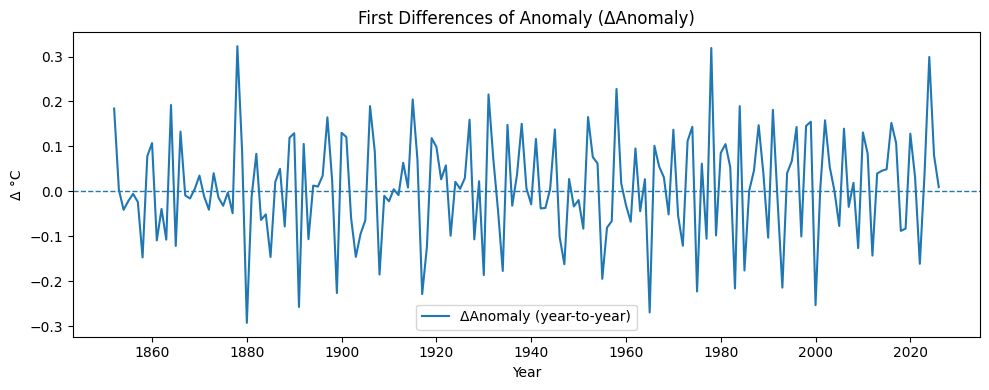

In [12]:
diff = ts['Anomaly'].diff().dropna()

plt.figure(figsize=(10,4))
plt.plot(diff.index.to_pydatetime(), diff.values, label='ΔAnomaly (year-to-year)')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('First Differences of Anomaly (ΔAnomaly)')
plt.xlabel('Year'); plt.ylabel('Δ °C'); plt.legend()
plt.tight_layout(); plt.show()


- **Centered at zero:** Year-to-year changes bounce around 0 → no leftover trend in the differences.
- **Bursts of larger moves:** Periods with consecutive positive or negative changes indicate **persistence** (changes aren’t purely random).
- **Magnitude:** Typical fluctuations are small (a few hundredths of a degree), with occasional years showing jumps near **±0.2–0.3 °C**.

**Conclusion:** ΔAnomaly shows **non-random clustering** of annual changes, suggesting some **serial dependence** in the short run (common in climate time series).


### **Lag Plots**

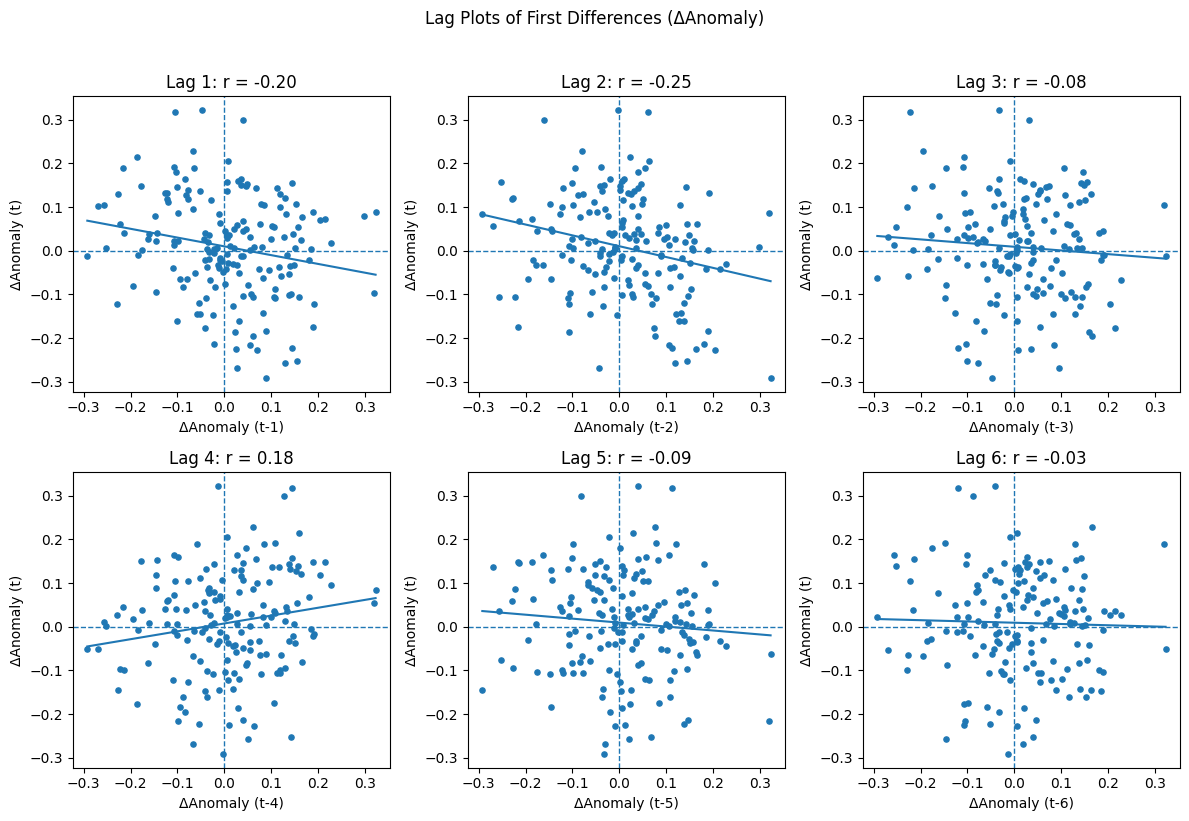

Pearson r by lag: {'lag_1': -0.20242107039942142, 'lag_2': -0.24948057726702533, 'lag_3': -0.08333213991502406, 'lag_4': 0.1778966113139705, 'lag_5': -0.08885165224733683, 'lag_6': -0.02844961771451604}


In [13]:
diff = ts["Anomaly"].diff().dropna()

lags = [1, 2, 3, 4, 5, 6]

n = len(lags)
rows = int(np.ceil(n/3))
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), squeeze=False)

for ax, k in zip(axes.ravel(), lags):
    x = diff.shift(k).dropna()
    y = diff.loc[x.index]

    ax.scatter(x.values, y.values, s=14)
    if len(x) > 1:
        m, b = np.polyfit(x.values, y.values, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        ax.plot(xs, m*xs + b)

    r = np.corrcoef(x.values, y.values)[0, 1]
    ax.set_title(f"Lag {k}: r = {r:.2f}")
    ax.set_xlabel(f"ΔAnomaly (t-{k})")
    ax.set_ylabel("ΔAnomaly (t)")
    ax.axhline(0, linestyle="--", linewidth=1)
    ax.axvline(0, linestyle="--", linewidth=1)

for j in range(n, rows*cols):
    fig.delaxes(axes.ravel()[j])

fig.suptitle("Lag Plots of First Differences (ΔAnomaly)", y=1.02)
fig.tight_layout()
plt.show()

corrs = {f"lag_{k}": float(np.corrcoef(diff.shift(k).dropna().values,
                                       diff.loc[diff.shift(k).dropna().index].values)[0,1])
         for k in lags}
print("Pearson r by lag:", corrs)


Lag plots of year-to-year changes (ΔAnomaly) show negative correlation at lags 1–2 (r ≈ −0.20 to −0.25), indicating partial mean-reversion in consecutive years. Correlations at higher lags are close to zero, with a small positive blip at lag 4 (r ≈ +0.18). Overall, serial dependence is short-lived and modest.

### What the lag-plot results mean for temperatures

- **Year-to-year “rate-of-change” tends to bounce back a bit.**  
  Because ΔAnomaly at lags 1–2 is **negative**, a year with a bigger-than-usual **increase** is often followed by a year with a **smaller increase or a slight dip** (and vice versa). That’s **partial mean-reversion** in the changes.

- **But the long-term level still goes up.**  
  This mean-reversion is **short-lived and modest**, so it **does not cancel** the long-run warming. 

- **Limited memory = limited short-term predictability.**  
  Since correlations fade after **1–2 years** and are small in size, temperatures don’t “remember” much beyond the very recent past. Short-term ups/downs are **noisy**, so we don’t expect strong multi-year predictability from these simple lags alone.

- **A tiny 4-year echo (weak).**  
  The small **positive** bump at lag 4 hints that every ~4 years there can be a mild tendency for changes to line up in the same direction, but it’s **weak**—could be chance or a faint imprint of multi-year climate variability (e.g., ocean–atmosphere patterns). **Not a headline.**


## **Conclusion**

This project analyzed **annual global temperature anomalies** using a simple **Trend + Remainder** framework, supported by a few targeted diagnostics.

- **Long-run trend.** A smooth trend (LOWESS or a 10-year centered mean) shows a **clear, persistent warming** across the record, with a visibly **steeper rise in recent decades**.
- **Uncertainty (95% band behavior).** The shaded 95% band is **wider in earlier decades** and **narrower in recent decades**, consistent with improved coverage and measurement. Importantly, in the modern period the **entire band sits mostly above 0**, indicating that, even when having the uncertainty in consideration, recent years are **warmer than the baseline**.

- **Remainder (after removing the trend).** The remainder oscillates around **zero**, indicating the trend captures the main structure. It shows **brief runs and occasional spikes**—the normal, short-run variability you expect from climate and measurement noise—without undermining the long-term rise.

- **Serial correlation (short-run dependence).** Lag plots of **year-to-year changes (ΔAnomaly)** reveal **modest, short-lived serial dependence** (noticeable at the first couple of lags). This means big changes can “carry over” briefly, but the memory fades quickly; it offers **limited short-term predictability**.



### Bottom line
The evidence points to a **robust, long-term warming** signal with **short-run wiggles** that are modest and transient. While year-to-year changes can cluster briefly and variability shifts across eras, none of these features overturns the central result: the global temperature anomaly has **trended upward** and remains **elevated relative to the historical baseline**.



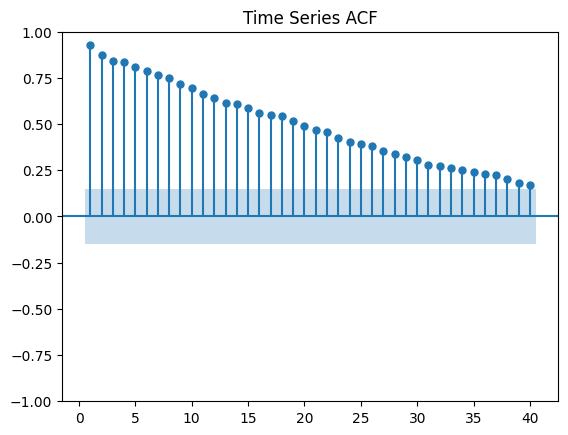

In [14]:
series = mytimeseries['Anomaly'].values
plot_acf(series, bartlett_confint=False, lags=40, zero=False, title="Time Series ACF");

The Time Series ACF reveals a clear correlation between the temperature of an year and the temperature of the years that follow, as was expected by the analysis of the Time Series already done. This also reinforces the idea of apply First Differences in order to remove the existing trend on the Time Series.

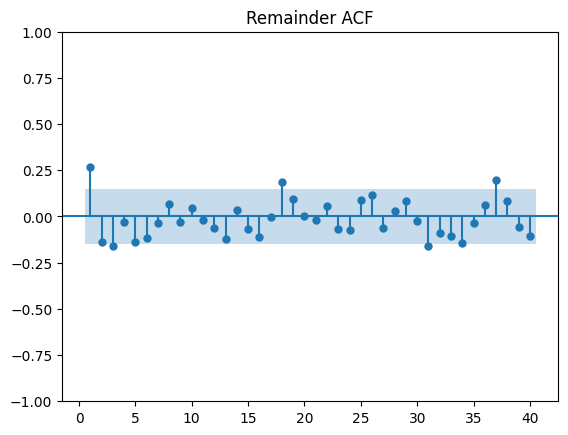

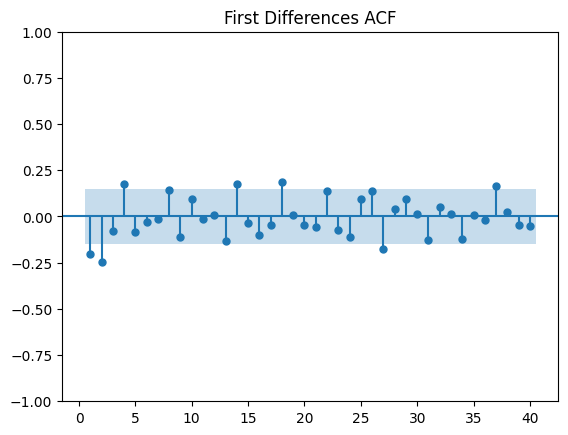

In [15]:
plot_acf(remainder, bartlett_confint=False, lags=40, zero=False, title="Remainder ACF");
plot_acf(diff, bartlett_confint=False, lags=40, zero=False, title="First Differences ACF");

Looking at the First Differences ACF, almost all lags are inside the confidence bounds, with exception of the first 2 lags which are still very close to the Industrial Revolution. The Remainder ACF tells the same story, only now only the first lag is clearly outside the bounds.However, there are many lags that are on the edge of the CB, which may indicate that further improvements are necessary to both of these metrics, in order to completely remove the trend.

## Modeling

### AR Model

In order to figure the adequate order for our AR model, we will need to analyse the PACF of our residuals.

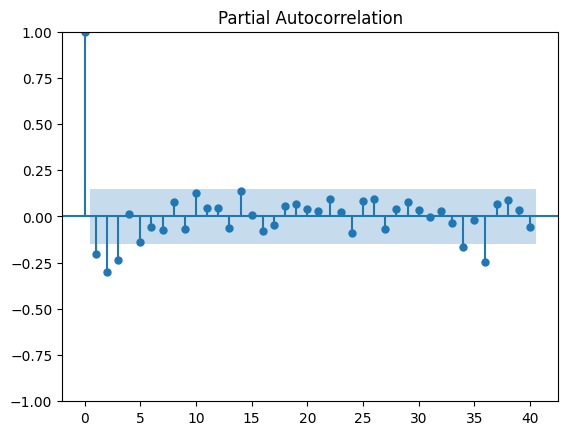

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(diff, lags=40, method='ywm')   # Yule-Walker modification, a mais recomendada para encontrar a ordem p para o modelo AR
plt.show()

By analysing the PACF, there is an evident cut in lag 3, which indicates that our AR model should have an order of 3. However, we will test AR models with order 1, 2 and 3 in order to reach a definite conclusion.

In [17]:
from statsmodels.tsa.ar_model import AutoReg

modelAR1 = AutoReg(diff, lags=1).fit()
modelAR2 = AutoReg(diff, lags=2).fit()
modelAR3 = AutoReg(diff, lags=3).fit()
print(modelAR1.summary())
print(modelAR2.summary())
print(modelAR3.summary())

                            AutoReg Model Results                             
Dep. Variable:                Anomaly   No. Observations:                  175
Model:                     AutoReg(1)   Log Likelihood                 130.776
Method:               Conditional MLE   S.D. of innovations              0.114
Date:                Mon, 08 Dec 2025   AIC                           -255.553
Time:                        12:52:59   BIC                           -246.075
Sample:                    12-31-1852   HQIC                          -251.708
                         - 12-31-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.009      1.156      0.248      -0.007       0.027
Anomaly.L1    -0.2011      0.074     -2.727      0.006      -0.346      -0.057
                                    Roots           

As expected, the AR(3) model outperformed the other 2 models in every metric. However, we must analyse if it is an adequate model by extracting its residuals and analysing them.

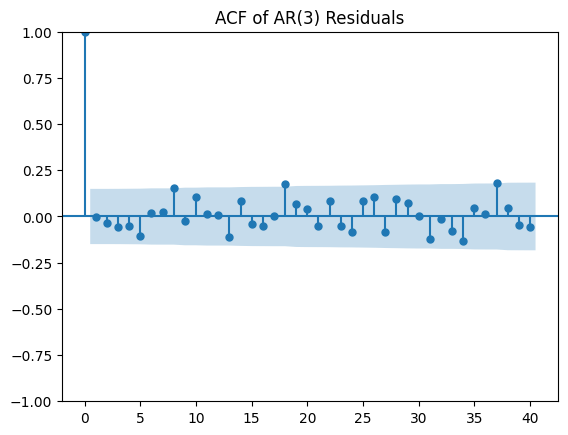

In [18]:
#Verificar os residuais do AR(3)
residualsAR3 = modelAR3.resid
plot_acf(residualsAR3, lags=40)
plt.title("ACF of AR(3) Residuals")
plt.show()


By plotting the residual ACF, it is evident that all lags are either clearly inside the threshold or bordering it. So, in order to reach a definite conclusion, we will use the Ljung-Box Statistic in order to measure the significance of this ACF.

In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung = acorr_ljungbox(residualsAR3, lags=[5, 10, 15, 20, 25, 30, 35, 40], return_df=True)
print(ljung)

      lb_stat  lb_pvalue
5    3.369856   0.643165
10  10.006137   0.439955
15  14.044914   0.522125
20  21.679960   0.358126
25  26.793200   0.366294
30  33.382943   0.306167
35  42.184854   0.188167
40  51.177569   0.110808


For our possible lag values given, the p_value of our LB statistic is always > 0.05, which means the null hypothesis can't be reject, meaning we can assume the AR(3) is an adequate model for our data.

### MA Model

When trying MA models, we must figure the q periods used for the MA(q) model. This is done by analysing the residuals ACF and find the lag where a cut-off is most evident (a cut-off is when until a certain lag all values are outside the confidence bounds, and after it all lags seem to fit inside the confidence bounds).

By looking at our original residual ACF, there is an evident cut-off on lag 2, which would indicate MA(2) was the model to use. However, just like with AR models, we will try MA(1), MA(2) and MA(3).

In [20]:
from statsmodels.tsa.arima.model import ARIMA

model_ma1 = ARIMA(diff, order=(0, 0, 1)).fit()
model_ma2 = ARIMA(diff, order=(0, 0, 2)).fit()
model_ma3 = ARIMA(diff, order=(0, 0, 3)).fit()
print(model_ma1.summary())
print(model_ma2.summary())
print(model_ma3.summary())

                               SARIMAX Results                                
Dep. Variable:                Anomaly   No. Observations:                  175
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 137.362
Date:                Mon, 08 Dec 2025   AIC                           -268.724
Time:                        12:53:00   BIC                           -259.230
Sample:                    12-31-1851   HQIC                          -264.873
                         - 12-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.004      2.095      0.036       0.001       0.016
ma.L1         -0.5263      0.061     -8.628      0.000      -0.646      -0.407
sigma2         0.0122      0.002      8.104      0.0

As expected, MA(2) was the superior model on all metrics. Now we must analyse its residuals to figure out its adequacy as a model, by plotting their ACF.

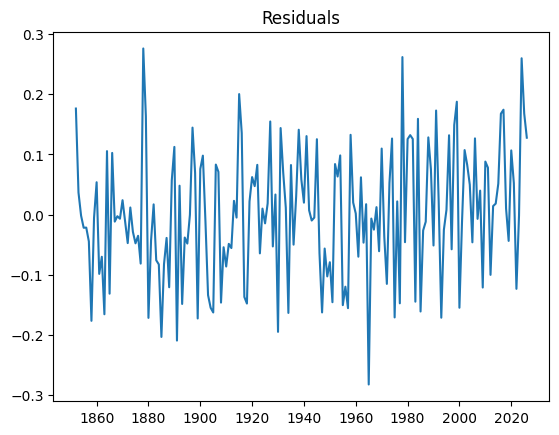

In [21]:
ma_resid = model_ma2.resid
plt.plot(ma_resid)
plt.title("Residuals")
plt.show()

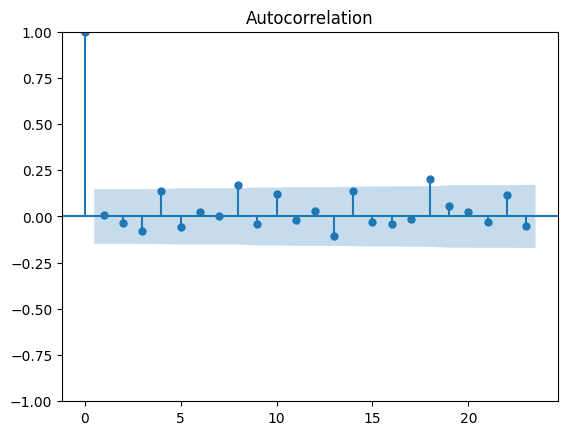

In [22]:
#Verificar a ACF dos residuais
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ma_resid)
plt.show()


Just like the AR(3) model, this ACF leaves some doubt on certain lags, especially lag 18. Therefore, we will once again calculate the Ljung-Box statistic to find a satisfiable conclusion.

In [23]:
ljungMA = acorr_ljungbox(ma_resid, lags=[5,10, 15, 20, 23], return_df=True)
print(ljungMA)

      lb_stat  lb_pvalue
5    5.362544   0.373254
10  13.737038   0.185328
15  20.071870   0.169193
20  29.069674   0.086397
23  32.582253   0.088627


Once again, as all p_values are over 0.05, this model can be considered an adequate model, and regarding statistics like AIC, BIC and HQIC the MA(2) is the better performing model compared to the AR(3) model. Since both models are adequate, we will now evaluate the performance of an ARMA(3,2) model, as these 2 models might complement each other to reach a better performing model.

### ARMA Model

In [24]:
model_arma32 = ARIMA(diff, order=(3,0,2)).fit()
print(model_arma32.summary())

                               SARIMAX Results                                
Dep. Variable:                Anomaly   No. Observations:                  175
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 146.963
Date:                Mon, 08 Dec 2025   AIC                           -279.926
Time:                        12:53:00   BIC                           -257.772
Sample:                    12-31-1851   HQIC                          -270.940
                         - 12-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.004      2.291      0.022       0.001       0.015
ar.L1         -0.5861      0.207     -2.837      0.005      -0.991      -0.181
ar.L2         -0.1129      0.202     -0.559      0.5

C:\Users\anarita.sanches\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\anarita.sanches\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\anarita.sanches\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

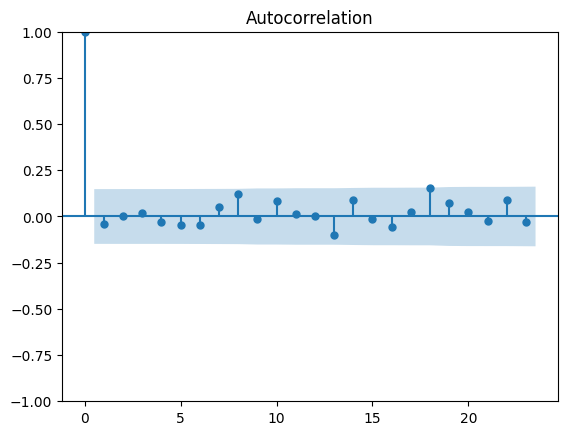

In [25]:
arma_resid = model_arma32.resid
plot_acf(arma_resid)
plt.show()

In [26]:
ljungARMA = acorr_ljungbox(arma_resid, lags=[5,10, 15, 20, 23], return_df=True)
print(ljungARMA)

      lb_stat  lb_pvalue
5    0.895402   0.970554
10   5.890936   0.824342
15   9.519978   0.848800
20  16.228977   0.702321
23  18.072364   0.753552


As expected the ARMA(3,2) model is adequate to our project, however by analysing its results with the MA(2) model, while the AIC is similar in both ARMA(3,2)'s BIC is significantly lower than MA(2)'s, as aparently the adition of more arguments did not produce a significantly better result. So, we can conclude that the MA(2) model is the best model for our data, and it should be the one used in the forecasting phase.
Since the model MA(2) is the most adequate, before moving on to modelling we need to ensure that the residuals are normally distributed, uncorrelated and check for outliers. 

#### Residual Analysis

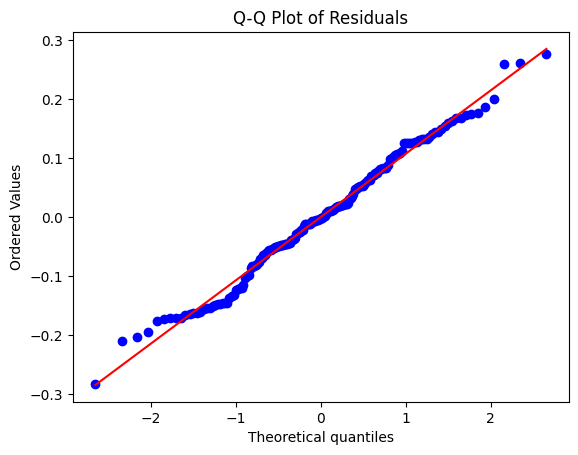

In [27]:
import scipy.stats as stats
##Q-Q plot (quantile-quantile plot; if residuals are normally distributed, the points must fall along the diagonal line)
stats.probplot(ma_resid, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

In [28]:
##Shapiro-Wilk test; p-value >0.05 then residuals are normally distributed
shapiro_stat, shapiro_pvalue = stats.shapiro(ma_resid)
print(f"Shapiro-Wilk statistic: {shapiro_stat:.4f}")
print(f"P-value: {shapiro_pvalue:.4f}")

Shapiro-Wilk statistic: 0.9894
P-value: 0.2156


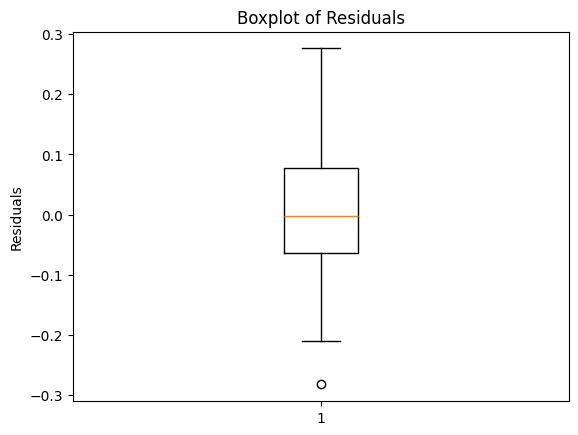

In [29]:
plt.boxplot(ma_resid)
plt.title("Boxplot of Residuals")
plt.ylabel("Residuals")
plt.show()

We can conclude that the residuals are uncorrelated (LJung test), normally distributed (Q-Q plot) and only contains one outlier (boxplot)

## Forecasting

In [30]:
h = 12  # forecast horizon, but we can choose another value
forecast = model_ma2.forecast(steps=h)
forecast_ci = model_ma2.get_forecast(steps=h).conf_int() #calculo dos confidence intervals

print(forecast)

2026-12-31   -0.080710
2027-12-31   -0.023572
2028-12-31    0.008108
2029-12-31    0.008108
2030-12-31    0.008108
2031-12-31    0.008108
2032-12-31    0.008108
2033-12-31    0.008108
2034-12-31    0.008108
2035-12-31    0.008108
2036-12-31    0.008108
2037-12-31    0.008108
Freq: YE-DEC, Name: predicted_mean, dtype: float64


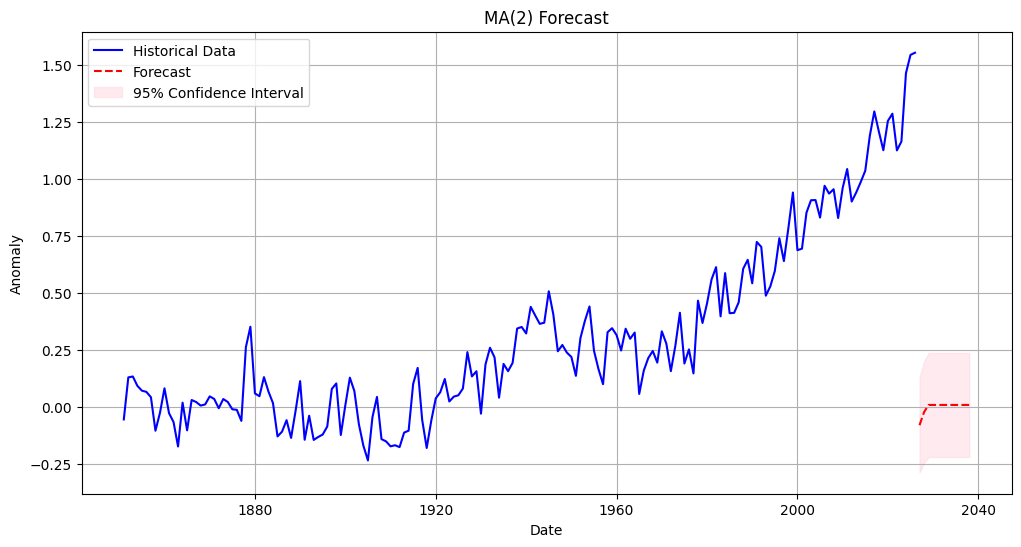

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts['Anomaly'], label='Historical Data', color='blue')
plt.plot(forecast.index, forecast, label='Forecast', color='red', linestyle='--')
plt.fill_between(forecast.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('MA(2) Forecast')
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.legend()
plt.grid(True)
plt.show()

The MA(2) forecast demonstrates a key characteristic of moving average models: forecasts beyond q=2 steps converge to the unconditional mean (0.008 in this case). This occurs because MA models have finite memory and only use the most recent q error terms. After 2 periods, the model has no additional information to incorporate, resulting in a flat forecast line.

In [32]:
# Split data: train on all but last 20 observations
train_size = len(ts) - 20
train_data = ts[:train_size]
test_data = ts[train_size:]

# Fit model on training data
model_train = ARIMA(train_data['Anomaly'], order=(0, 0, 2))
fitted_train = model_train.fit()

# Forecast the test period
forecast_test = fitted_train.forecast(steps=20)

# Calculate forecast errors
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(test_data['Anomaly'], forecast_test)
rmse = np.sqrt(mean_squared_error(test_data['Anomaly'], forecast_test))
mape = np.mean(np.abs((test_data['Anomaly'] - forecast_test) / test_data['Anomaly'])) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 0.9044
RMSE: 0.9418
MAPE: 78.20%


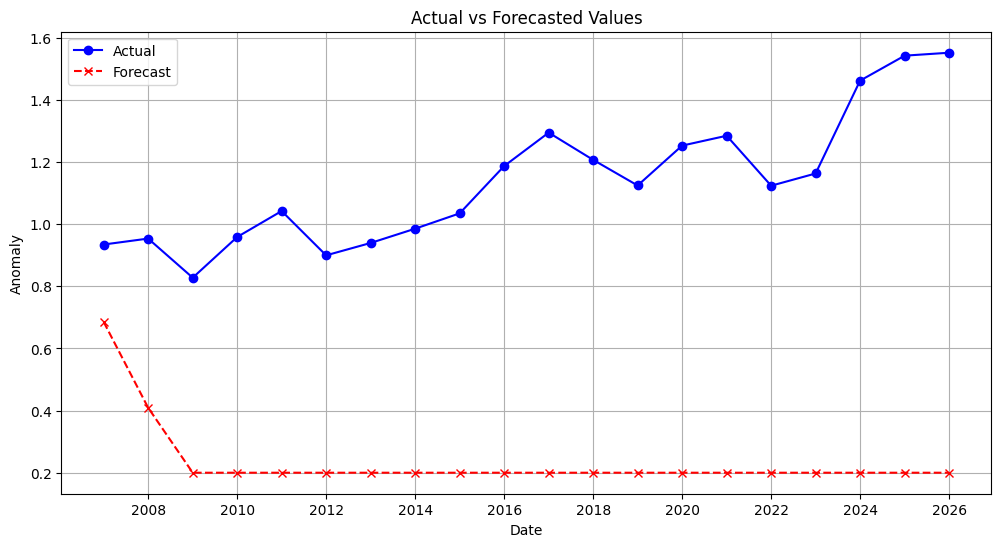

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Anomaly'], label='Actual', color='blue', marker='o')
plt.plot(test_data.index, forecast_test, label='Forecast', color='red', marker='x', linestyle='--')
plt.title('Actual vs Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
for h in [1, 2, 5, 10, 20]:
    forecast_h = model_ma2.forecast(steps=h)
    print(f"\nForecast {h} steps ahead:")
    print(forecast_h)


Forecast 1 steps ahead:
2026-12-31   -0.08071
Freq: YE-DEC, dtype: float64

Forecast 2 steps ahead:
2026-12-31   -0.080710
2027-12-31   -0.023572
Freq: YE-DEC, Name: predicted_mean, dtype: float64

Forecast 5 steps ahead:
2026-12-31   -0.080710
2027-12-31   -0.023572
2028-12-31    0.008108
2029-12-31    0.008108
2030-12-31    0.008108
Freq: YE-DEC, Name: predicted_mean, dtype: float64

Forecast 10 steps ahead:
2026-12-31   -0.080710
2027-12-31   -0.023572
2028-12-31    0.008108
2029-12-31    0.008108
2030-12-31    0.008108
2031-12-31    0.008108
2032-12-31    0.008108
2033-12-31    0.008108
2034-12-31    0.008108
2035-12-31    0.008108
Freq: YE-DEC, Name: predicted_mean, dtype: float64

Forecast 20 steps ahead:
2026-12-31   -0.080710
2027-12-31   -0.023572
2028-12-31    0.008108
2029-12-31    0.008108
2030-12-31    0.008108
2031-12-31    0.008108
2032-12-31    0.008108
2033-12-31    0.008108
2034-12-31    0.008108
2035-12-31    0.008108
2036-12-31    0.008108
2037-12-31    0.008108
20

With this we can see that the model MA(2) converges to the mean after 2 steps. In order to try to overpass the MA(2) limitation, one possibilty is to apply the forecast 1-step ahead at each time

In [35]:
# Rolling 1-step ahead forecasts
predictions = []
for i in range(len(test_data)):
    train_temp = ts[:train_size + i]
    model_temp = ARIMA(train_temp['Anomaly'], order=(0, 0, 2))
    fitted_temp = model_temp.fit()
    pred = fitted_temp.forecast(steps=1)
    predictions.append(pred.values[0])

Step 1: Actual = 0.9349, Predicted = 0.6855
Step 2: Actual = 0.9540, Predicted = 0.6479
Step 3: Actual = 0.8279, Predicted = 0.6311
Step 4: Actual = 0.9591, Predicted = 0.5644
Step 5: Actual = 1.0427, Predicted = 0.7089
Step 6: Actual = 0.9000, Predicted = 0.7660
Step 7: Actual = 0.9399, Predicted = 0.5399
Step 8: Actual = 0.9859, Predicted = 0.7029
Step 9: Actual = 1.0352, Predicted = 0.7381
Step 10: Actual = 1.1874, Predicted = 0.6934
Step 11: Actual = 1.2952, Predicted = 0.9196
Step 12: Actual = 1.2075, Predicted = 0.9189
Step 13: Actual = 1.1250, Predicted = 0.7709
Step 14: Actual = 1.2534, Predicted = 0.8039
Step 15: Actual = 1.2852, Predicted = 0.9557
Step 16: Actual = 1.1242, Predicted = 0.8953
Step 17: Actual = 1.1636, Predicted = 0.7239
Step 18: Actual = 1.4626, Predicted = 0.9020
Step 19: Actual = 1.5431, Predicted = 1.1775
Step 20: Actual = 1.5526, Predicted = 1.0470

=== Rolling 1-Step Ahead Forecast Performance ===
MAE: 0.3493
RMSE: 0.3648
MAPE: 30.54%


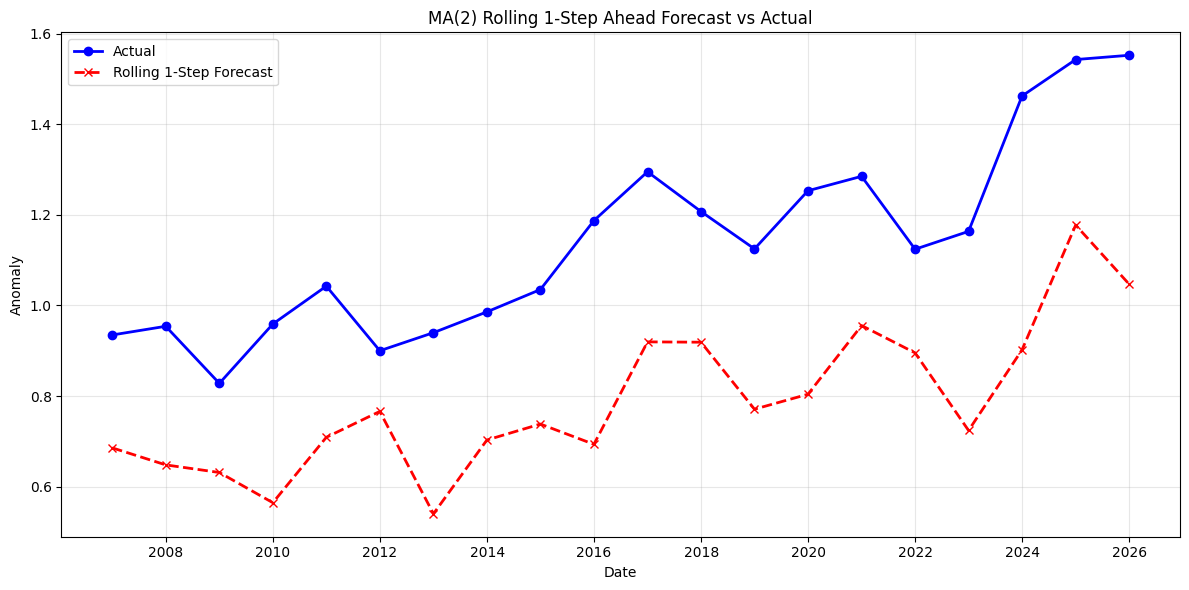

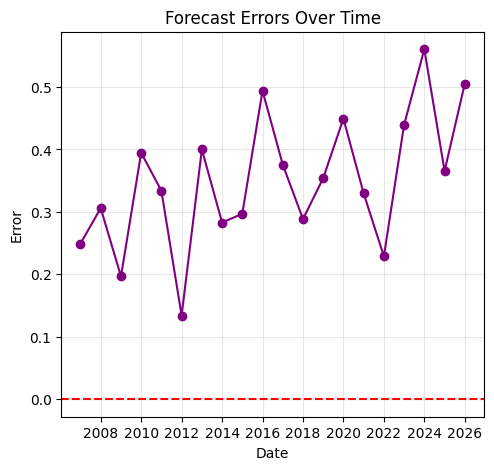

In [37]:
# Step 1: Split your data
train_size = len(ts) - 20  # Reserve last 20 observations for testing
train_data = ts[:train_size]
test_data = ts[train_size:]

# Step 2: Rolling 1-step ahead forecasts
predictions_1step = []
actual_values = []

for i in range(len(test_data)):
    # Expand training set by one observation each iteration
    train_temp = ts[:train_size + i]
    
    # Fit MA(2) model
    model_temp = ARIMA(train_temp['Anomaly'], order=(0, 0, 2))
    fitted_temp = model_temp.fit()
    
    # Forecast 1 step ahead
    pred = fitted_temp.forecast(steps=1)
    predictions_1step.append(pred.values[0])
    actual_values.append(test_data['Anomaly'].iloc[i])
    
    print(f"Step {i+1}: Actual = {test_data['Anomaly'].iloc[i]:.4f}, Predicted = {pred.values[0]:.4f}")

# Step 3: Calculate performance metrics
predictions_1step = np.array(predictions_1step)
actual_values = np.array(actual_values)

mae_1step = mean_absolute_error(actual_values, predictions_1step)
rmse_1step = np.sqrt(mean_squared_error(actual_values, predictions_1step))
mape_1step = np.mean(np.abs((actual_values - predictions_1step) / actual_values)) * 100

print(f"\n=== Rolling 1-Step Ahead Forecast Performance ===")
print(f"MAE: {mae_1step:.4f}")
print(f"RMSE: {rmse_1step:.4f}")
print(f"MAPE: {mape_1step:.2f}%")

# Step 4: Visualize rolling forecasts
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, actual_values, label='Actual', color='blue', marker='o', linewidth=2)
plt.plot(test_data.index, predictions_1step, label='Rolling 1-Step Forecast', color='red', marker='x', linestyle='--', linewidth=2)
plt.title('MA(2) Rolling 1-Step Ahead Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 5: Plot forecast errors
errors = actual_values - predictions_1step

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(test_data.index, errors, color='purple', marker='o')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Forecast Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid(True, alpha=0.3)


The rolling forecast evaluation demonstrates that MA(2) provides reliable short-term predictions (1-step ahead), with accuracy degrading for longer horizons. Thus, since we need longer-term forecasts, we will apply the ARMA model since it combines both behaviours.

In [38]:
# Fit ARMA(3,2) on full data
model_arma = ARIMA(ts['Anomaly'], order=(3, 0, 2))
fitted_arma = model_arma.fit()
print(fitted_arma.summary())

# Generate long-term forecast (12 steps ahead)
h = 12
forecast_arma = fitted_arma.forecast(steps=h)
forecast_arma_ci = fitted_arma.get_forecast(steps=h).conf_int()

print("\n=== ARMA(3,2) Forecast ===")
print(forecast_arma)

C:\Users\anarita.sanches\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\anarita.sanches\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                Anomaly   No. Observations:                  176
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 141.285
Date:                Mon, 08 Dec 2025   AIC                           -268.571
Time:                        14:44:56   BIC                           -246.377
Sample:                    12-31-1850   HQIC                          -259.569
                         - 12-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6225      0.606      1.028      0.304      -0.565       1.810
ar.L1          1.4351      0.463      3.099      0.002       0.527       2.343
ar.L2         -0.7496      0.659     -1.137      0.2

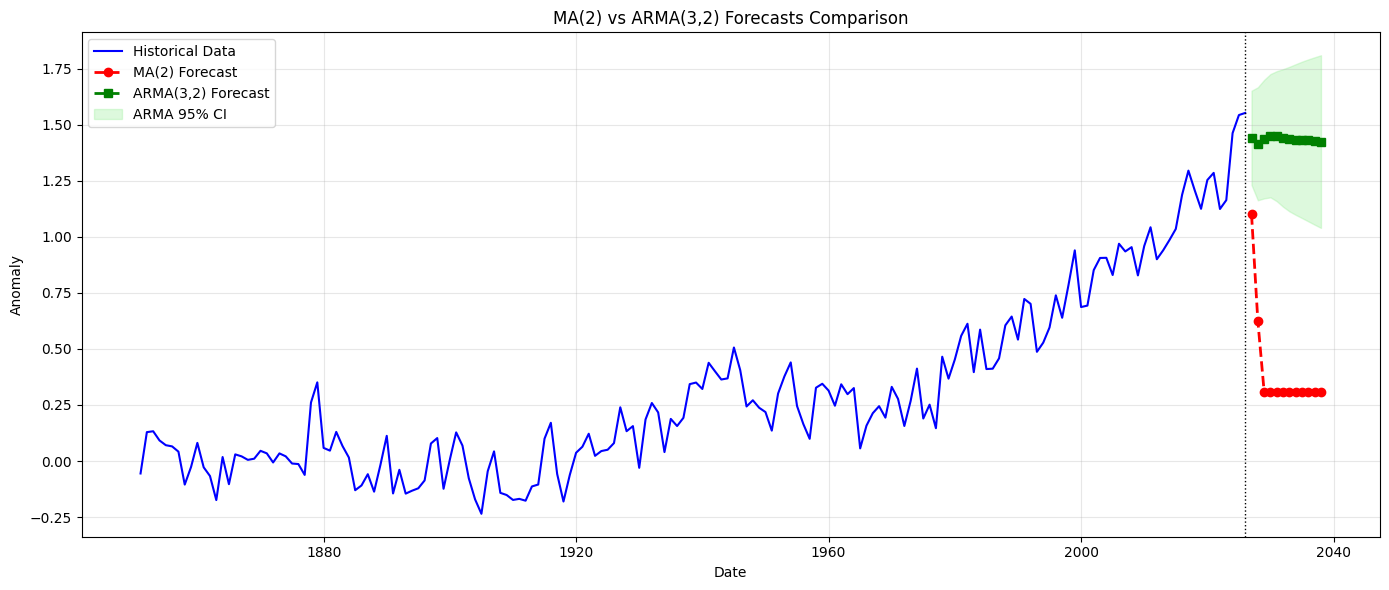

In [39]:
# Also get MA(2) forecast for comparison
model_ma = ARIMA(ts['Anomaly'], order=(0, 0, 2))
fitted_ma = model_ma.fit()
forecast_ma = fitted_ma.forecast(steps=h)

# Plot comparison
plt.figure(figsize=(14, 6))
plt.plot(ts.index, ts['Anomaly'], label='Historical Data', color='blue', linewidth=1.5)
plt.plot(forecast_ma.index, forecast_ma, label='MA(2) Forecast', color='red', linestyle='--', marker='o', linewidth=2)
plt.plot(forecast_arma.index, forecast_arma, label='ARMA(3,2) Forecast', color='green', linestyle='--', marker='s', linewidth=2)
plt.fill_between(forecast_arma.index, 
                 forecast_arma_ci.iloc[:, 0], 
                 forecast_arma_ci.iloc[:, 1], 
                 color='lightgreen', alpha=0.3, label='ARMA 95% CI')
plt.title('MA(2) vs ARMA(3,2) Forecasts Comparison')
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=ts.index[-1], color='black', linestyle=':', linewidth=1)
plt.tight_layout()
plt.show()

In [40]:
# Split data
train_size = len(ts) - 20
train_data = ts[:train_size]
test_data = ts[train_size:]

# Rolling forecasts for MA(2)
predictions_ma = []
for i in range(len(test_data)):
    train_temp = ts[:train_size + i]
    model_temp = ARIMA(train_temp['Anomaly'], order=(0, 0, 2))
    fitted_temp = model_temp.fit()
    pred = fitted_temp.forecast(steps=1)
    predictions_ma.append(pred.values[0])

# Rolling forecasts for ARMA(3,2)
predictions_arma = []
for i in range(len(test_data)):
    train_temp = ts[:train_size + i]
    model_temp = ARIMA(train_temp['Anomaly'], order=(3, 0, 2))
    fitted_temp = model_temp.fit()
    pred = fitted_temp.forecast(steps=1)
    predictions_arma.append(pred.values[0])

predictions_ma = np.array(predictions_ma)
predictions_arma = np.array(predictions_arma)
actual_values = test_data['Anomaly'].values

# Calculate metrics for both models
mae_ma = mean_absolute_error(actual_values, predictions_ma)
rmse_ma = np.sqrt(mean_squared_error(actual_values, predictions_ma))
mape_ma = np.mean(np.abs((actual_values - predictions_ma) / actual_values)) * 100

mae_arma = mean_absolute_error(actual_values, predictions_arma)
rmse_arma = np.sqrt(mean_squared_error(actual_values, predictions_arma))
mape_arma = np.mean(np.abs((actual_values - predictions_arma) / actual_values)) * 100

print("\n=== Rolling 1-Step Ahead Forecast Comparison ===")
print(f"\nMA(2) Performance:")
print(f"  MAE:  {mae_ma:.4f}")
print(f"  RMSE: {rmse_ma:.4f}")
print(f"  MAPE: {mape_ma:.2f}%")

print(f"\nARMA(3,2) Performance:")
print(f"  MAE:  {mae_arma:.4f}")
print(f"  RMSE: {rmse_arma:.4f}")
print(f"  MAPE: {mape_arma:.2f}%")

print(f"\nImprovement:")
print(f"  MAE:  {((mae_ma - mae_arma) / mae_ma * 100):.2f}%")
print(f"  RMSE: {((rmse_ma - rmse_arma) / rmse_ma * 100):.2f}%")

C:\Users\anarita.sanches\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\anarita.sanches\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\anarita.sanches\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-st


=== Rolling 1-Step Ahead Forecast Comparison ===

MA(2) Performance:
  MAE:  0.3493
  RMSE: 0.3648
  MAPE: 30.54%

ARMA(3,2) Performance:
  MAE:  0.1033
  RMSE: 0.1264
  MAPE: 8.71%

Improvement:
  MAE:  70.42%
  RMSE: 65.36%


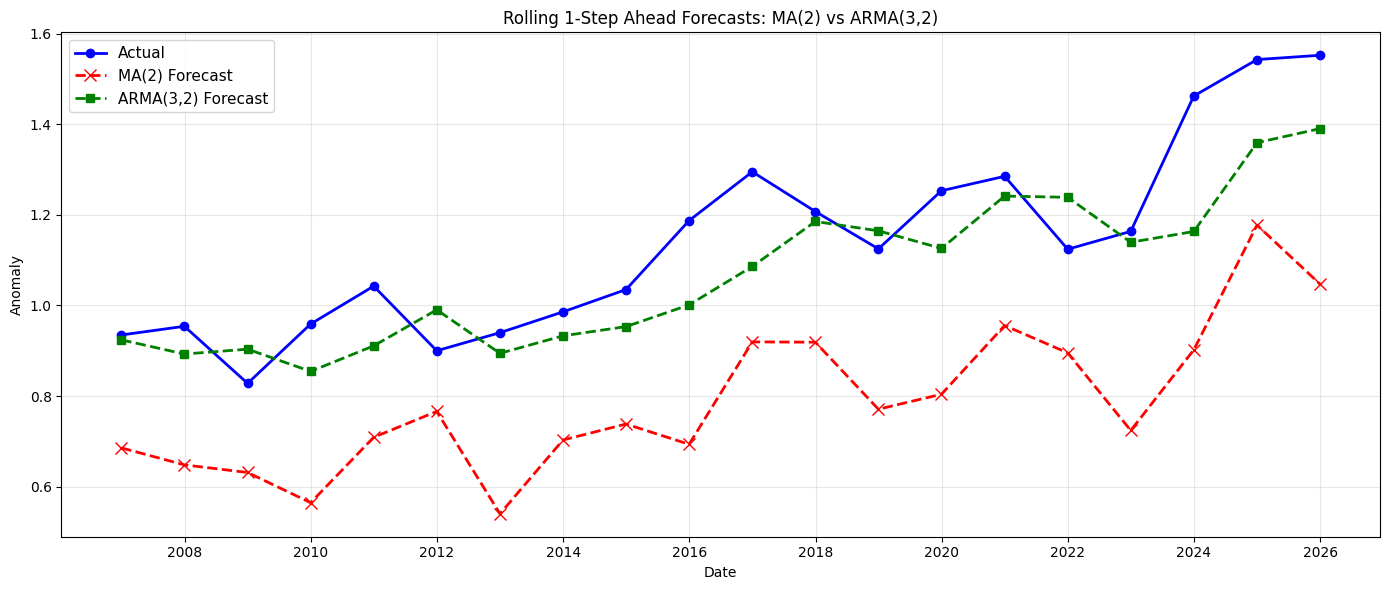

In [41]:
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, actual_values, label='Actual', color='blue', marker='o', linewidth=2, markersize=6)
plt.plot(test_data.index, predictions_ma, label='MA(2) Forecast', color='red', marker='x', linestyle='--', linewidth=2, markersize=8)
plt.plot(test_data.index, predictions_arma, label='ARMA(3,2) Forecast', color='green', marker='s', linestyle='--', linewidth=2, markersize=6)
plt.title('Rolling 1-Step Ahead Forecasts: MA(2) vs ARMA(3,2)')
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [43]:
# Error distribution ARMA(3,2)
errors_arma = actual_values - predictions_arma
axes[1, 0].hist(errors_arma, bins=10, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 0].set_title('ARMA(3,2) Error Distribution')
axes[1, 0].set_xlabel('Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

While MA(2) demonstrated the best in-sample fit based on AIC/BIC criteria, its forecasting capability is limited due to the finite memory property of moving average models. To address this limitation, we also evaluated the ARMA(3,2) model for forecasting purposes. The ARMA model combines autoregressive components that provide longer memory, potentially improving forecast accuracy beyond 2-step horizons.